<a href="https://colab.research.google.com/github/sagasucksatlife1/QunatProjects/blob/main/PairsTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview
Built a cointegration-based pairs trading strategy to exploit mean-reverting relationships between correlated stocks.


In [232]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels as stat
import matplotlib.pyplot as plt
import seaborn as sns


In [233]:
stocks = yf.download(['GOOGL', 'MSFT', 'META', 'NVDA', 'AAPL','GS','MS'], start="2018-01-01",
    interval="1d"
)['Close']

stocks.head()
stocks.dropna()
stocks.info()

/tmp/ipython-input-1212505784.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stocks = yf.download(['GOOGL', 'MSFT', 'META', 'NVDA', 'AAPL','GS','MS'], start="2018-01-01",
[*********************100%***********************]  7 of 7 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2004 entries, 2018-01-02 to 2025-12-19
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2004 non-null   float64
 1   GOOGL   2004 non-null   float64
 2   GS      2004 non-null   float64
 3   META    2004 non-null   float64
 4   MS      2004 non-null   float64
 5   MSFT    2004 non-null   float64
 6   NVDA    2004 non-null   float64
dtypes: float64(7)
memory usage: 125.2 KB


we download the data for the stock prices on a dialy closing interval, For the Pair Tradding project.

**AIM - TO FIND HIGH CORRELTATION STOCKS TO TRADE IN A PAIR TRADE**

In [234]:
correlation = stocks.corr()
correlation.head()

Ticker,AAPL,GOOGL,GS,META,MS,MSFT,NVDA
Ticker,,,,,,,
AAPL,1.000000,0.928724,0.872533,0.800649,0.923769,0.965466,0.830459
GOOGL,0.928724,1.000000,0.944483,0.868474,0.955003,0.938892,0.894847
GS,0.872533,0.944483,1.000000,0.909713,0.979788,0.899654,0.945834
META,0.800649,0.868474,0.909713,1.000000,0.861263,0.878706,0.948665
MS,0.923769,0.955003,0.979788,0.861263,1.000000,0.923634,0.894295


Generating a correlation table to find highly correlated stocks.
Pair AAPL(Apple) AND MSFT(Miscrosoft) are the two but after doing the pair trading returns were too low so rejecting.
So choosing the pair, MS(Morgan Stanley) and GS(Goldman Sacs).

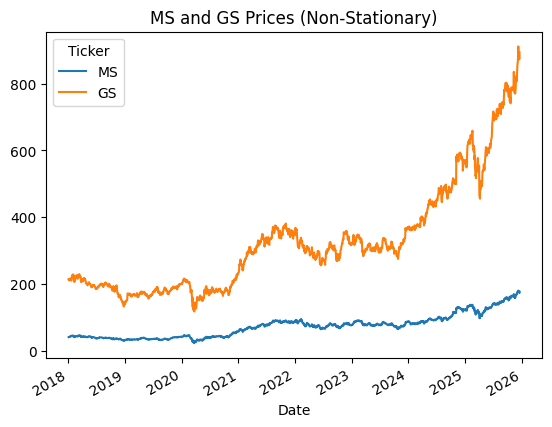

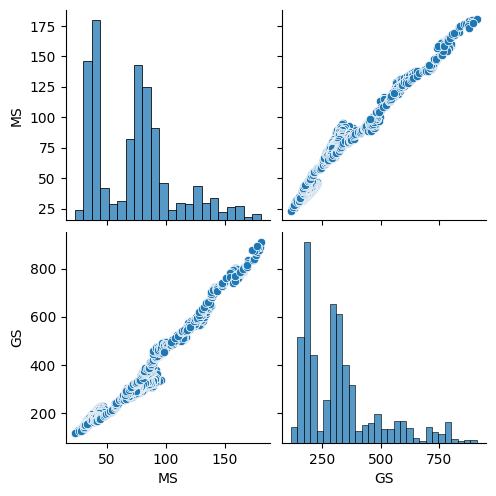

In [235]:
stocks[['MS','GS']].plot(title="MS and GS Prices (Non-Stationary)")
plt.show()
sns.pairplot(stocks[["MS","GS"]])

We plot curve and see the high correlation through th epiar plot and the line plot.  

In [236]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series,name):
  result = adfuller(series)
  print(f"ADF Test STATS for {name} :", result[0])
  print("p_test value:", result[1])
  if result[1] < 0.05:
    print("Time series is stationary")
  else:
    print("Time series is non-stationary")

Creating a funtion to identify the non stationary Time series by appling the ADF test and using an additonal P-test if less than 0.05 then rejecting the unit Root hypothesis.

In [237]:

  adf_test(stocks['MS'], "MORGAN STANLEY")

  adf_test(stocks['GS'], "GOLDMAN")



ADF Test STATS for MORGAN STANLEY : 1.107848644412432
p_test value: 0.9952830540209301
Time series is non-stationary
ADF Test STATS for GOLDMAN : 2.8274806341397163
p_test value: 1.0
Time series is non-stationary


Since the Time Series is Not-Stationary thus we co-integrate them to generate a Stationary time Series

In [238]:
import statsmodels.api as sm
A = stocks['MS']
B = stocks['GS']
B_const = sm.add_constant(B)
model = sm.OLS(A,B_const).fit()
alpha = model.params[0]
beta = model.params[1]
print("the value of alpha running OLS for min. error :", alpha)
print("the value of beta running OLS for min. error :", beta)


the value of alpha running OLS for min. error : 6.76462965325392
the value of beta running OLS for min. error : 0.20353702823645625


/tmp/ipython-input-2576671087.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]
/tmp/ipython-input-2576671087.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


after running a Co-integartion test using OLS method we determine the best fitting aplha and beta, then minimise the spread or the error.

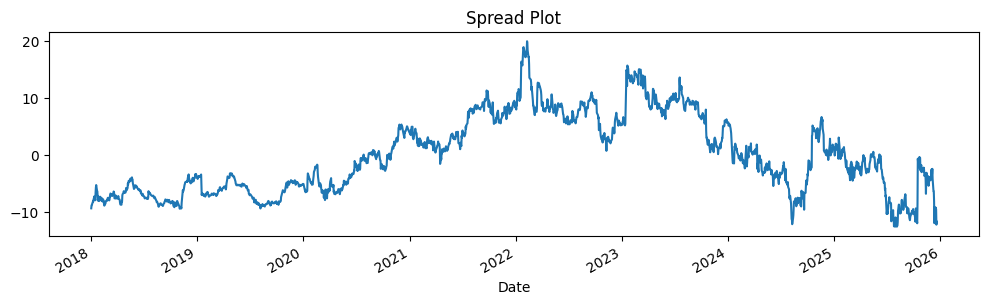

In [239]:
spread = model.resid
spread = A - (alpha + beta*B)
spread.plot(figsize=(12,3))
plt.title("Spread Plot")
plt.show()

We plot the spread line graph and it look like a stationary curve, Constant Mean, Constant SD and not seasonality.

In [240]:
adf_test(spread,"spread")

ADF Test STATS for spread : -2.2226078438366903
p_test value: 0.19814266503609806
Time series is non-stationary


Running the test for spread stationary using the funtions that is already defined... SPREAD IS STATIONARY TIME SERIES.

[]

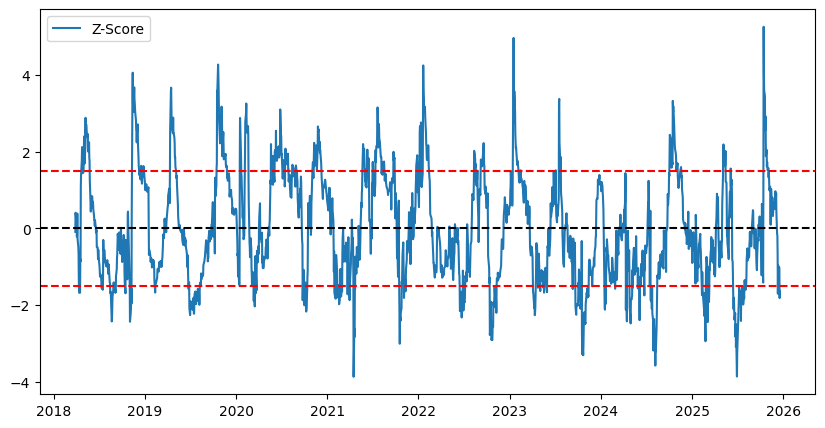

In [241]:
window = 60
rolling_mean = spread.rolling(window).mean()
rolling_std = spread.rolling(window).std()
z_score = (spread - rolling_mean)/rolling_std
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(z_score, label="Z-Score")
plt.axhline(1.5,color = "r", linestyle="--")
plt.axhline(-1.5,color = "r", linestyle="--")
plt.axhline(0,color = "black", linestyle="--")
plt.legend()
plt.plot()



Even though the time series is stationary there are massive fluctations and the mean might turn out irrelevant for different time frames. thus we rolling mean and SD for a window of 60 days to calaculate z score...

WHY DO WE CALCULATE Z-SCORE?

BECAUSE OF THE FACT THAT WE DONT KNOW WHAT FLUCTATIONS IN THE TIME SEREIS ARE NORMAL AND WHAT ARE ABNORMALS... SO BY CALACUTING THE Z SCORE WE CAN SEE THE EXTREME HIGH FLUCTION FROM THE AVG FLUCTATIONS.

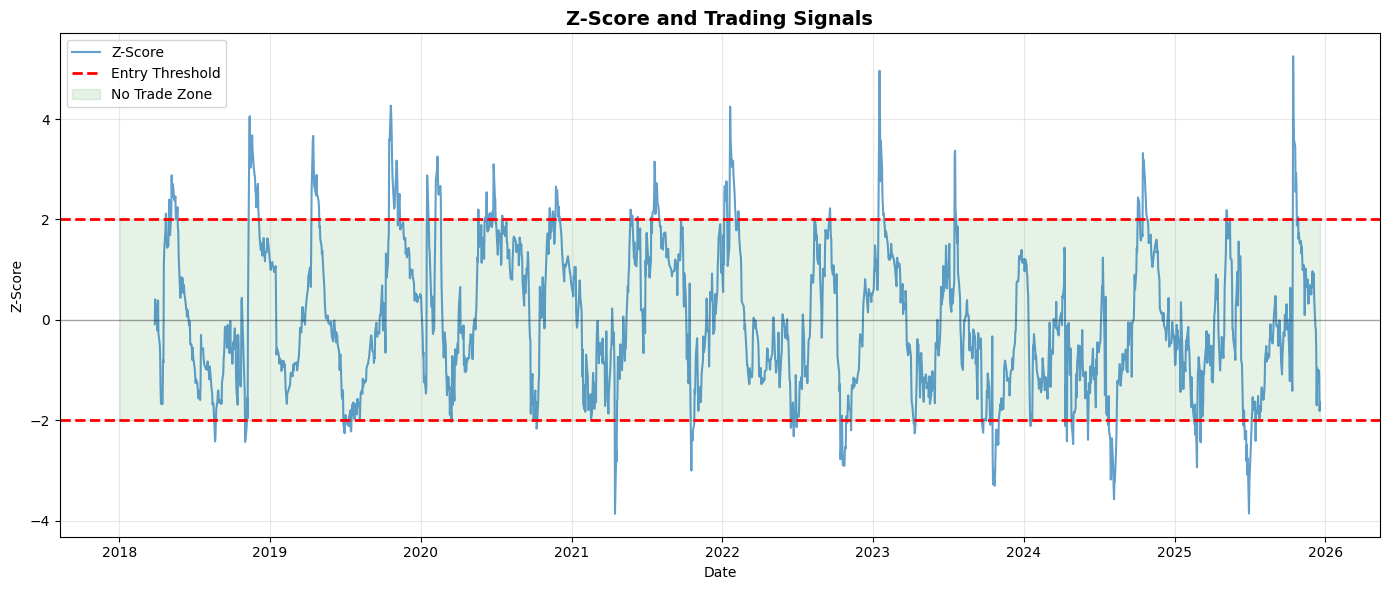

In [242]:
plt.figure(figsize=(14, 6))
plt.plot(z_score.index, z_score, label='Z-Score', alpha=0.7, linewidth=1.5)
plt.axhline(2, color='r', linestyle='--', label='Entry Threshold', linewidth=2)
plt.axhline(-2, color='r', linestyle='--', linewidth=2)
plt.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=1)
plt.fill_between(z_score.index, -2, 2, alpha=0.1, color='green', label='No Trade Zone')
plt.title('Z-Score and Trading Signals', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

*The extremely high fluctions are the ones where actual mis-pricing takes place and  that is where we can take postion and hold to earn profit....
if Z score is above 1.5 than we sell as the share A is overpriced and if the z score is below -1.5 than we buy A as it is relatively underpriced.... we do the oppsite with the share B and buy betaB and in the latter case we sell betaB*

In [243]:
import pandas as pd

signals = pd.DataFrame(index=z_score.index)
signals['z'] = z_score

signals['signal'] = 0
signals.loc[signals['z'] > 1.5, 'signal'] = -1   # short spread
signals.loc[signals['z'] < -1.5, 'signal'] = 1   # long spread
signals['position'] = signals['signal'].replace(0, np.nan).fillna(method='ffill').fillna(0) # hold
signals.loc[signals['z'].abs() == 0, 'position'] = 0 # exit


/tmp/ipython-input-1676747648.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  signals['position'] = signals['signal'].replace(0, np.nan).fillna(method='ffill').fillna(0) # hold


**There have been a few error in thi spahse of the project intialiy my z score requiremnt was 2 which was too conservative and i didnt make any returns so now its 1.5 and the positions turns to 0 only then the Zscore absolute value turns to 0.**

signals.loc[signals['z'] > 1.5, 'signal'] = -1   # short spread
signals.loc[signals['z'] < -1.5, 'signal'] = 1   # long spread

we enter  with a buy when z score is less than 1.5. and vice a versa and exit when z score reaches 0.

In [244]:
import pandas as pd
import numpy as np
position_size = 100000
prices = pd.DataFrame({
    'MS': stocks['MS'],
    'GS': stocks['GS'],
    'position': signals['position']
}).dropna()
prices['ret_A'] = prices['MS'].pct_change()
prices['ret_B'] = prices['GS'].pct_change()
prices['position_lag'] = prices['position'].shift(1)
prices['pnl'] = (
    prices['position_lag']
    * position_size
    * (prices['ret_A'] - beta * prices['ret_B'])
)
prices = prices.dropna()

This is a simple step.. u get a base dataframe with closing price and postion we took in the previous code block... we calutae the returns by pct.change for each stock to claculate the p&l... we create a position lag and where our todays trade equals tommorows p&l then we put the entire p&l formula to claute the p&l.
**to backtest i used backtesting.py software before but i only consdcuted 2 tardes and had a retrun of 0 why as it only conducted one postions at a time while we were coduction 2 a buy and a sell. and why only two trades god-knows**

In [249]:

initial_capital = 1_000_000
prices['equity'] = initial_capital + prices['pnl'].cumsum()
prices['peak'] = prices['equity'].cummax()
prices['drawdown'] = prices['equity'] - prices['peak']
prices['drawdown_pct'] = prices['drawdown'] / prices['peak']



this is the part where we anaylse performance and calculate every aspects of the curve. total equity... peak, brakdown and breakbown pct

In [246]:
daily_returns = prices['pnl'] / initial_capital

sharpe = (
    np.sqrt(252)
    * daily_returns.mean()
    / daily_returns.std()
)

total_return = (prices['equity'].iloc[-1] / initial_capital - 1) * 100
max_dd = prices['drawdown_pct'].min() * 100

print("Total Return %:", round(total_return, 2))
print("Sharpe Ratio :", round(sharpe, 2))
print("Max Drawdown %:", round(max_dd, 2))


Total Return %: 14.5
Sharpe Ratio : 0.67
Max Drawdown %: -4.1


final performance metrics are clalculated using sharpe ratio for the risk metrics and the retuns for the performance metric.

Total Return %: 14.5,
Sharpe Ratio : 0.67

 we had a breakdown of perfomance of 4.1 that means we could have been that much in profit on top of 14.5 but no worries.
 max drawdown of -4.1% is EXCELLENT (most strategies have 10-20%)

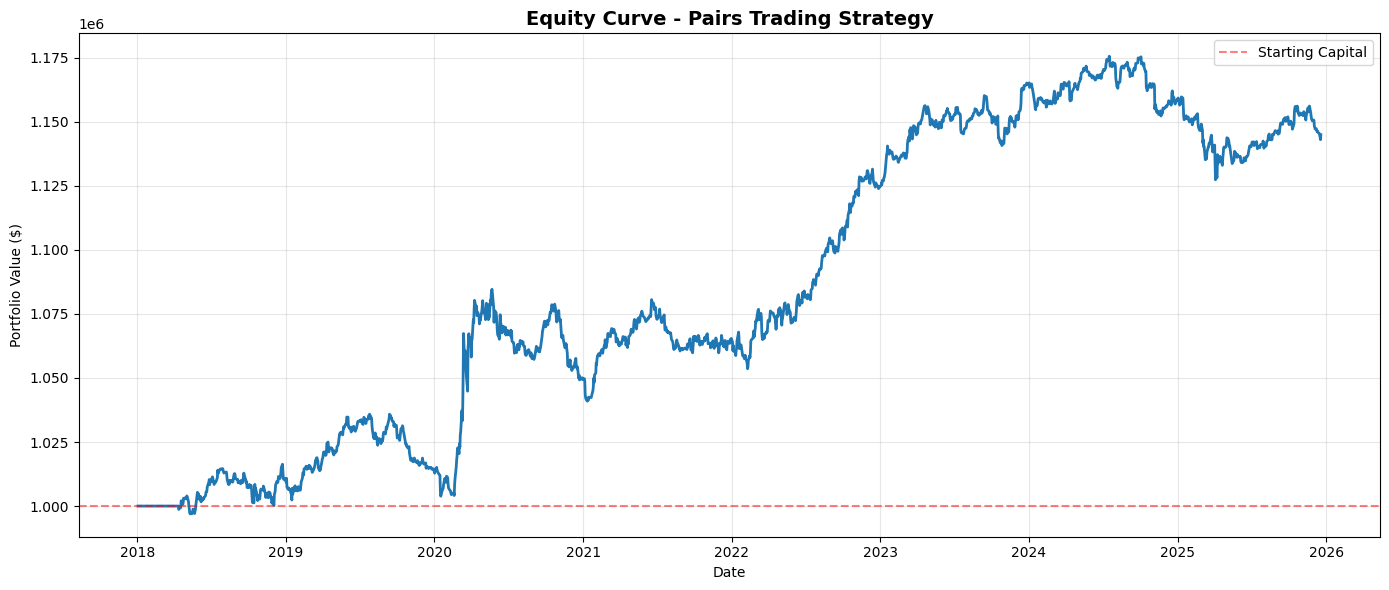

In [247]:
plt.figure(figsize=(14, 6))
plt.plot(prices.index, prices['equity'], linewidth=2)
plt.axhline(initial_capital, color='r', linestyle='--', alpha=0.5, label='Starting Capital')
plt.title('Equity Curve - Pairs Trading Strategy', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


plot showing the performance of thr curve overtime...
PROJECT COMPLETE 🥳